In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import os
import sys

import torch
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2
from einops import rearrange

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# local imports
root_dir = os.path.abspath(os.path.join('..', '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from data_modules import urbansyn
from urbansyn_segformer import UrbanSynSegFormer

Data preparation

In [2]:
# Download the UrbanSyn dataset from the huggingface hub.
# It is 21 GB in size, so it might take several minutes
us = urbansyn.UrbanSynDownloader(os.path.join(root_dir, 'data'))
us.download()

# Downscale the original data by a factor of 2 and 4.
# This produces images of size 256x512 for fast training.
# Downscaling may also take a while.
for factor in [2, 4]:
    us.downscale(factor)

c:\main\repos\computer-vision\data\urbansyn already exists.
c:\main\repos\computer-vision\data\urbansyn_resized\512 already exists.
c:\main\repos\computer-vision\data\urbansyn_resized\256 already exists.


Taking a look at a train data example

torch.Size([16, 3, 512, 1024]) torch.Size([16, 512, 1024])


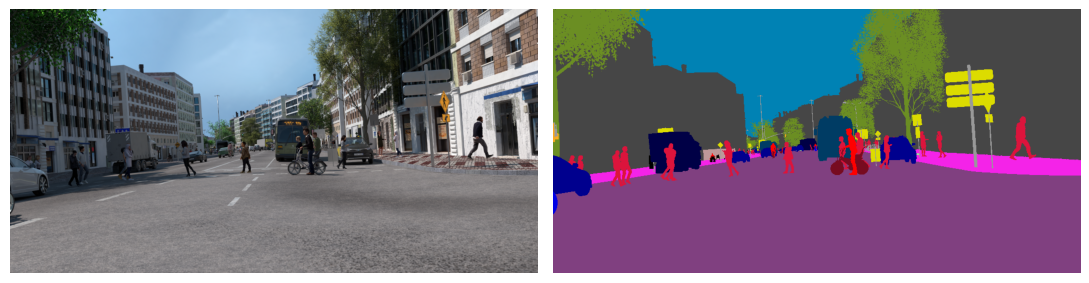

In [3]:
datamodule = us.get_datamodule(downscaling=2)
datamodule.setup('fit')
for x, y in datamodule.train_dataloader():
    print(x.size(), y.size())
    fig,ax = plt.subplots(1, 2, figsize=(11,3))
    ax[0].imshow(rearrange(urbansyn.INV_NORMALIZE(x[0]), 'c h w -> h w c'))
    ax[0].axis('off')
    ax[1].imshow(urbansyn.colorize_segmap(y, for_pil=True)[0])
    ax[1].axis('off')
    plt.tight_layout()
    # plt.savefig('../../img/urbansyn_example.png')
    plt.show()
    break

Finetuning a SegFormer pretrained on Cityscapes

In [4]:
DEBUG = False

LR = 1e-4
LR_GAMMA = 0.99
BATCH_SIZE = 16
IMAGE_DOWNSCALING = 4

LOAD_BEST_CHECKPOINT = False
LOAD_LAST_CHECKPOINT = False
load_version = f'D4_B16_LR0.0001_LRG0.99'

OVERRIDE_HP = False  # if you are loading a checkpoint but want to use the hyperparameters specified above

version_name = f'D{IMAGE_DOWNSCALING}_B{BATCH_SIZE}_LR{LR}_LRG{LR_GAMMA}'

if LOAD_BEST_CHECKPOINT:
    lightning_model = UrbanSynSegFormer.load_from_checkpoint('best.ckpt')
elif LOAD_LAST_CHECKPOINT:
    lightning_model = UrbanSynSegFormer.load_from_checkpoint(os.path.join('lightning_logs', load_version, 'last.ckpt'))
else:
    lightning_model = UrbanSynSegFormer(learning_rate=LR, lr_gamma=LR_GAMMA)

if OVERRIDE_HP:
    lightning_model.hparams['learning_rate'] = LR
    lightning_model.lr = LR 
    lightning_model.hparams['lr_gamma'] = LR_GAMMA
    lightning_model.lr_gamma = LR_GAMMA

print(lightning_model.hparams)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join('lightning_logs', version_name),  # Where to save the checkpoints
    filename='{epoch}-{val_loss:.4f}',  # Filename format
    monitor='val_loss',  # Metric to monitor
    save_last=True,  # Always save the last checkpoint
)

logger = TensorBoardLogger('.', version=version_name)

trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=200),
                             LearningRateMonitor(logging_interval='epoch'),
                             checkpoint_callback],
                  fast_dev_run=DEBUG,
                  max_epochs=500,
                  precision='bf16-mixed',
                  logger=logger,
                 )

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


"learning_rate": 0.0001
"lr_gamma":      0.99


In [5]:
datamodule = us.get_datamodule(batch_size=BATCH_SIZE, downscaling=IMAGE_DOWNSCALING)

In [6]:
trainer.fit(lightning_model, datamodule=datamodule)

c:\main\repos\computer-vision\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\main\repos\computer-vision\experiments\urbansyn_segformer\lightning_logs\D4_B16_LR0.0001_LRG0.99 exists and is not empty.

  | Name    | Type                             | Params | Mode 
---------------------------------------------------------------------
0 | model   | SegformerForSemanticSegmentation | 3.7 M  | eval 
1 | loss_fn | DiceLoss                         | 0      | train
2 | metrics | MeanIoU                          | 0      | train
---------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.876    Total estimated model params size (MB)
3         Modules in train mode
213       Modules in eval mode
c:\main\repos\computer-vision\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many w

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Loading trained model and evaluating it

In [10]:
# specify the desired checkpoint here:
checkpoint_path = 'best.ckpt'
lightning_model = UrbanSynSegFormer.load_from_checkpoint(checkpoint_path)
datamodule = us.get_datamodule(batch_size=16, downscaling=2)
trainer = Trainer()
validation = trainer.validate(lightning_model, datamodule=datamodule)

c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
GPU available: True (cuda), used: True
TPU avail

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │     0.377922922372818     │
│         val_loss          │    0.3614068329334259     │
└───────────────────────────┴───────────────────────────┘

Showing results for a small validation batch and a demo image

In [7]:
# specify the desired checkpoint here:
checkpoint_path = 'best.ckpt'
lightning_model = UrbanSynSegFormer.load_from_checkpoint(checkpoint_path)
trainer = Trainer(limit_predict_batches=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.


Predicting: |          | 0/? [00:00<?, ?it/s]

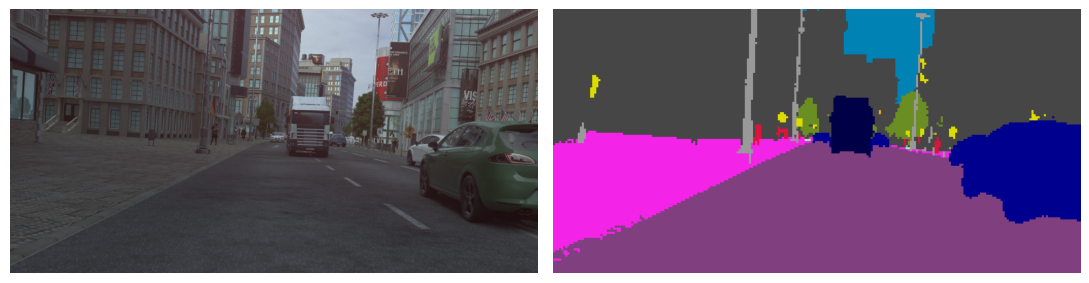

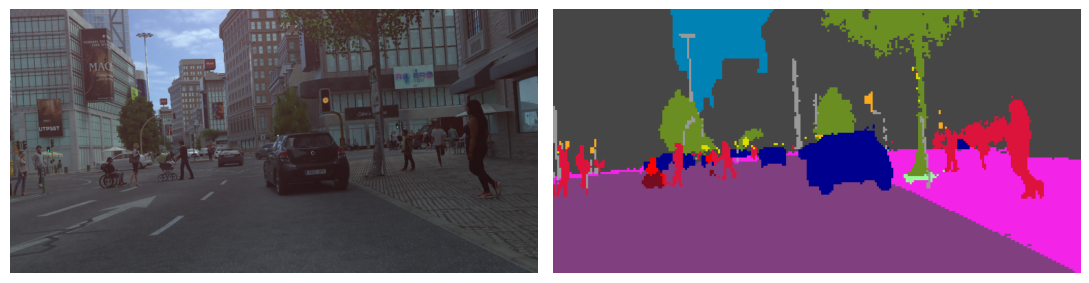

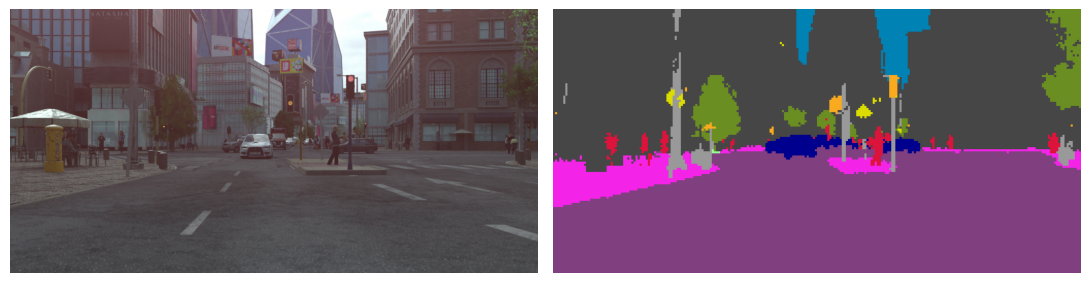

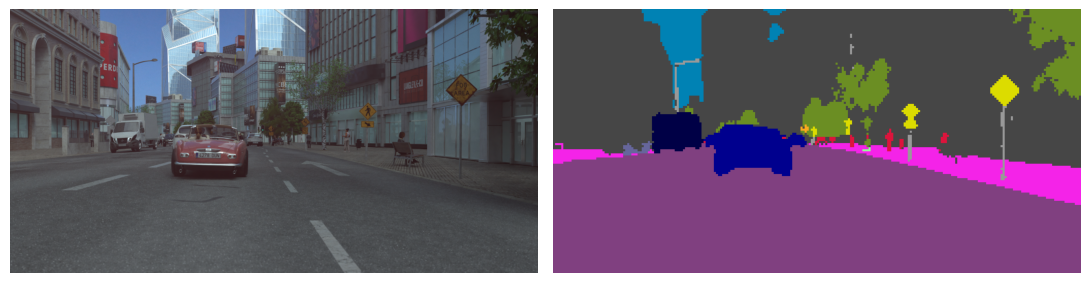

In [8]:
num_images = 4

datamodule = us.get_datamodule(batch_size=num_images, downscaling=2)
datamodule.setup('predict')
batch = next(iter(datamodule.predict_dataloader()))

output = trainer.predict(lightning_model, datamodule=datamodule)[0].detach().cpu()
segmaps = urbansyn.colorize_segmap(torch.argmax(output, 1), for_pil=True)

for image, segmap in zip(batch, segmaps):
    fig,ax = plt.subplots(1, 2, figsize=(11,3))
    ax[0].imshow(rearrange(urbansyn.INV_NORMALIZE(image), 'c h w -> h w c'))
    ax[0].axis('off')
    ax[1].imshow(segmap)
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

Predicting: |          | 0/? [00:00<?, ?it/s]

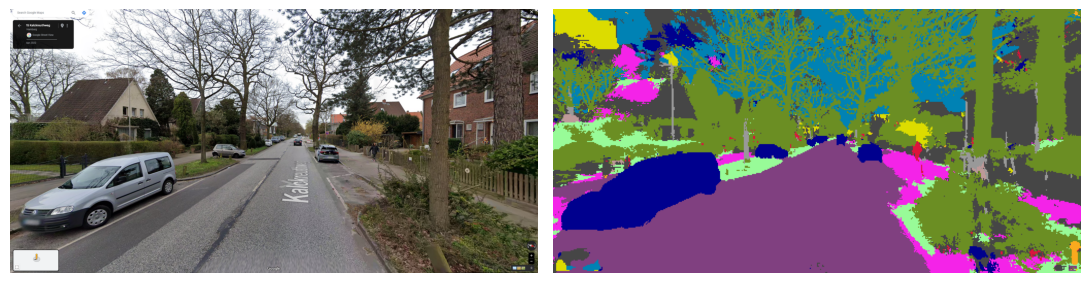

In [9]:
input_path = os.path.join(root_dir, 'data', 'Kalckreuthweg.png')
input = np.array(Image.open(input_path).convert('RGB'))
transform = A.Compose([A.Normalize(), ToTensorV2()])
x = transform(image=input)['image'].unsqueeze(0).unsqueeze(0)

output = trainer.predict(lightning_model, x)[0].detach().cpu()
segmap = urbansyn.colorize_segmap(torch.argmax(output, 1), for_pil=True)[0]

fig,ax = plt.subplots(1, 2, figsize=(11,3))
ax[0].imshow(input)
ax[0].axis('off')
ax[1].imshow(segmap)
ax[1].axis('off')
plt.tight_layout()
# plt.savefig('../../img/kalckreuthweg_results.png')
plt.show()